# Jitter model for TOLIMAN
In order to properly recover the signal seen by TOLIMAN, we need to understand and account for the jitter of the spacecraft. In this notebook we will to develop a basic jitter model with dLux.

----

First let's get the housekeeping out of the way.

In [126]:
import dLux as dl
from jax import numpy as np
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt
import os

os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Let's set our physical parameters for modelling Alpha Centauri:

In [41]:
sep = 10  # binary separation in arcseconds
pa = 90  # position angle in degrees
flux = 6.229e7 / 10 / 2  # AVERAGE flux of the two stars per frame
contrast = 3.372873  # flux contrast from V band magnitudes
bandwidth_min = 545  # minimum wavelength in nm
bandwidth_max = 645  # maximum wavelength in nm

And our parameters for the optical system:

In [83]:
pixel_scale_in = 10e-7  # Radians per pixel of the detector
wavefront_npixels = 256  # Number of pixels representing the wavefront
detector_npixels = 128  # Number of pixels in the detector
sampling_rate = 5  # five times Nyquist sampling
wavels = 1e-9 * np.linspace(bandwidth_min, bandwidth_max, 3)  # the wavelengths modelled
detector_pixel_size = dl.utils.get_pixel_scale(sampling_rate, wavels.max(), 0.125)  # radians per pixel

Loading in the binary phase mask:

In [84]:
mask_dir = 'data/test_mask.npy'
mask = dl.optics.AddOPD(dl.utils.phase_to_opd(np.load(mask_dir), wavelength=wavels.mean()))

Let's create the system optics and source and combine them to create the instrument:

In [85]:
# Creating a propagator layer which will perform the PSF shifting:
propagator = dl.AngularMFT(detector_npixels, pixel_scale_in, name='Propagator')

# Make optical system
optics = dl.utils.toliman(wavefront_npixels,
                          detector_npixels,
                          detector_pixel_size=dl.utils.radians_to_arcseconds(detector_pixel_size),
                          extra_layers=[mask],#, propagator],
                          angular=True,
                          )

# Resetting the pixel scale of output
optics = optics.set(['AngularMFT.pixel_scale_out'], [dl.utils.arcseconds_to_radians(.3)])

# Creating a model Alpha Cen source
source = dl.BinarySource(separation=dl.utils.arcseconds_to_radians(sep),
                         wavelengths=wavels,
                         contrast=contrast,
                         flux=flux,
                         position_angle=np.deg2rad(pa),
                         )

# Creating the instrument by combining optics and source
tel = dl.Instrument(optics=optics, sources=[source])

Defining a function for plotting PSFs:

In [123]:
def plot_psf(PSF):
    fig, ax = plt.subplots()
    c = ax.imshow(PSF**.5)
    ax.set(
            # title=r'$\alpha$ $Cen$ Simulated sqrt PSF',
            xticks=[0, PSF.shape[0] - 1],
            yticks=[0, PSF.shape[1] - 1],
            )
    fig.colorbar(c, ax=ax, label='photons')
    plt.show()
    return

Adding noise to the PSF and then plotting (no jitter):

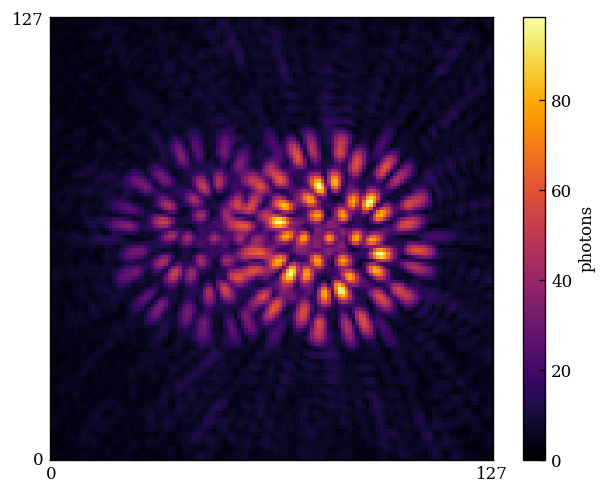

In [131]:
PSF = tel.model()

# adding noise
key = jr.PRNGKey(0)
PSF = jr.poisson(key, PSF)  # photon noise
# TODO fix negative values on sqrt scaling
# det_noise = np.round(2 * jr.normal(key, PSF.shape), decimals=0).astype(int)  # detector noise
# PSF += det_noise

plot_psf(PSF)

In [136]:
optics.propagate

Partial(<function Optics.propagate at 0x15dd748b0>, Optics(
  layers={
    'CreateWavefront':
    CreateWavefront(
      name='CreateWavefront',
      npixels=256,
      diameter=f32[],
      wavefront_type='Angular'
    ),
    'CircularAperture':
    StaticAperture(name='CircularAperture', aperture=f32[256,256]),
    'AddOPD':
    AddOPD(name='AddOPD', opd=f32[256,256]),
    'NormaliseWavefront':
    NormaliseWavefront(name='NormaliseWavefront'),
    'AngularMFT':
    AngularMFT(
      name='AngularMFT',
      inverse=False,
      npixels_out=128,
      pixel_scale_out=1.4544410433286078e-06,
      shift=f32[2],
      pixel_shift=False
    )
  }
))

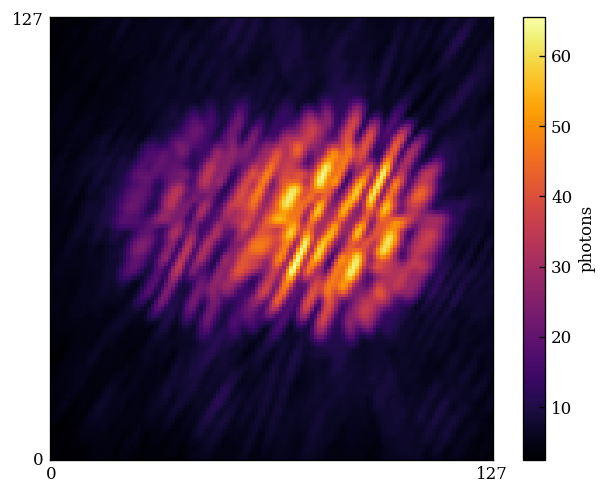

In [142]:
def set_and_model(optics, source, pos):
    src = source.set(['position'], [pos])
    return optics.model(src)

npsf = 10  # number of PSFs

pscale = optics.AngularMFT.pixel_scale_out  # arcseconds per pixel

# defining positions
centre = np.array([0, 0])  # pixels
xs = np.linspace(0, 5, npsf)  # pixels
ys = np.linspace( 0, 10, npsf)  # pixels
positions = pscale * (np.stack([xs, ys], axis=1) + centre)  # arcseconds

# vmap to vectorise positions
vmap_prop = vmap(set_and_model, in_axes=(None, None, 0))

# Propagate the wavelengths through the optics
psfs = vmap_prop(optics, source, positions)
jit_psf = psfs.sum(0) / npsf

plot_psf(jit_psf)

In [122]:
optics.propagate?